Setting Library

In [30]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

exchange_session = soup.find('div', class_='ExchangeSession')
if exchange_session is not None:
    session_id = exchange_session.get('data-sessionid')
    
    # Lấy mã phiên giao dịch hiện tại từ trang web của cafef
    url = 'https://www.cafef.vn/lich-su-giao-dich-HAG-1.chn'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    session_id = soup.find('div', class_='ExchangeSession').get('data-sessionid')Real-time-data-vndirect

    # Lấy dữ liệu cổ phiếu HAG theo phút từ API của cafef
    url = f'https://priceboard.cafef.vn/realtime/chart/MinuteChart/?symbol=HAG&floorCode=HSX&sessionID={session_id}'
    response = requests.get(url)
    data = response.json()

    # Chuyển đổi dữ liệu JSON thành dataframe
    df = pd.DataFrame(data['Data'])
    df = df[['time', 'open', 'high', 'low', 'close', 'volume']]
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('time', inplace=True)
    df = df.resample('1T').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})

    print(df.head())
else:
    print('Không tìm thấy session_id')



Không tìm thấy session_id


Load data

In [ ]:
financial_health_rating('HAG')

,industryEn,loanDeposit,badLoanGrossLoan,badLoanAsset,provisionBadLoan,ticker,financialHealth,netDebtEquity,currentRatio,quickRatio,interestCoverage,netDebtEBITDA
0,Farming & Fishing,None,None,None,None,HAG,2.8,2,3,3,3,3


In [ ]:
ticker_overview('HAG')

,exchange,shortName,industryID,industryIDv2,industry,industryEn,establishedYear,noEmployees,noShareholders,foreignPercent,website,stockRating,deltaInWeek,deltaInMonth,deltaInYear,outstandingShare,issueShare,companyType,ticker
0,HOSE,Hoàng Anh Gia Lai,217,3573,Thực phẩm và đồ uống,Food & Beverage,2006,1565,54114,0.023,http://www.hagl.com.vn,3.6,-0.003,-0.129,0.005,927.4,927.5,CT,HAG


In [ ]:
price_board('HAG')

,Mã CP,Giá Khớp Lệnh,KLBD/TB5D,T.độ GD,KLGD ròng(CM),%KLGD ròng (CM),RSI,MACD Volume,MACD Signal,Tín hiệu KT,...,Khối lượng Dư mua,Khối lượng Dư bán,Khớp nhiều nhất,seq,vnid3d,vnid1m,vnid3m,vnid1y,vnipe,vnipb
0,HAG,7790.0,0.53,1.22,0,0.0,38.1318,-0.03,Neutral,Neutral,...,217200,79500,7800,1677225540,-1.4,-6.2,9.9,-31.3,11.8157,1.56427


In [ ]:
df =  stock_historical_data(symbol='GMD', start_date="2000-01-01", end_date='2022-09-22') # truy xuất lịch sử giá của cổ phiếu GMD
df.head()

,Open,High,Low,Close,Volume,TradingDate
0,5173.0,5173.0,5173.0,5173.0,19500,2002-04-22
1,5270.0,5270.0,5270.0,5270.0,16900,2002-04-23
2,5367.0,5367.0,5367.0,5367.0,36800,2002-04-24
3,5355.0,5355.0,5355.0,5355.0,23400,2002-04-25
4,5355.0,5355.0,5355.0,5355.0,16500,2002-04-26


In [ ]:
stock_intraday_data(symbol='HAG', page_num=0, page_size=5000)

,price,volume,cp,rcp,a,ba,sa,hl,pcp,time
0,7790.0,377300,0.0,0.0,,0.0,0.0,True,0.0,14:45:00
1,7810.0,4600,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:59
2,7810.0,1000,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:59
3,7810.0,4400,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:59
4,7810.0,600,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:49
...,...,...,...,...,...,...,...,...,...,...
3433,7890.0,5000,0.0,0.0,BU,0.0,0.0,False,0.0,09:15:47
3434,7830.0,100,0.0,0.0,BU,0.0,0.0,False,0.0,09:15:38
3435,7810.0,100,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:33
3436,7810.0,100,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:23


In [ ]:
def crawl(company):
    start = "2020-01-15" 
    end = today = dt.datetime.now().strftime("%Y-%m-%d") 
    df = vnstock.stock_historical_data(symbol = company, start_date = start, end_date = end)
    df.to_csv(f"./data/raw/{company}.csv",encoding = "utf-8")

fhandle = open("./data/companylist.txt","r")
for line in fhandle.readlines():
    company = line.strip()
    print(f"{company}'s stock", end=' ')
    crawl(company)

FPT's stock CTG's stock LCG's stock 

In [ ]:
#Company list
companies = []
fhandle = open("./data/companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock


In [ ]:
company = 'FPT'
df = pd.read_csv(f"data/raw/{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,33119.0,33816.0,33119.0,33700.0,1942970,2020-01-16
1,1,33700.0,33758.0,33119.0,33467.0,1388810,2020-01-17
2,2,33409.0,33700.0,33235.0,33351.0,1227100,2020-01-20
3,3,33584.0,33700.0,32247.0,32247.0,4351820,2020-01-21
4,4,31957.0,32828.0,31782.0,32828.0,3165650,2020-01-22
...,...,...,...,...,...,...,...
770,770,81600.0,83000.0,81400.0,82800.0,1277504,2023-02-20
771,771,82800.0,83700.0,82600.0,82800.0,841841,2023-02-21
772,772,82300.0,82500.0,81800.0,81800.0,748561,2023-02-22
773,773,81700.0,81700.0,80600.0,81400.0,1161953,2023-02-23


Preprocessing data

In [ ]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [ ]:
#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Labels
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28

df['AR'] = df['H-L']/df['O-C']
#Median
df[f'ME_{MA1}'] = df['Close'].rolling(window = MA1).median()
df[f'ME_{MA2}'] = df['Close'].rolling(window = MA2).median()
df[f'ME_{MA3}'] = df['Close'].rolling(window = MA3).median()
df[f'ME_{MA4}'] = df['Close'].rolling(window = MA4).median()
#Rank 
df[f'RANK_{MA1}'] = df['Close'].rolling(window = MA1).rank()
df[f'RANK_{MA2}'] = df['Close'].rolling(window = MA2).rank()
df[f'RANK_{MA3}'] = df['Close'].rolling(window = MA3).rank()
df[f'RANK_{MA4}'] = df['Close'].rolling(window = MA4).rank()

#Var
df[f'VAR_{MA1}'] = df['Close'].rolling(window = MA1).var()
df[f'VAR_{MA2}'] = df['Close'].rolling(window = MA2).var()
df[f'VAR_{MA3}'] = df['Close'].rolling(window = MA3).var()
df[f'VAR_{MA4}'] = df['Close'].rolling(window = MA4).var()

#Simple moving average
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()
df[f'SMA_{MA4}'] = df['Close'].rolling(window = MA4).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA2}'] = df['Close'].rolling(window = MA2).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()
df[f'SD_{MA4}'] = df['Close'].rolling(window = MA4).std()

#Skewness
df[f'Ske_{MA1}'] = df['Close'].rolling(window = MA1).skew()
df[f'Ske_{MA2}'] = df['Close'].rolling(window = MA2).skew()
df[f'Ske_{MA3}'] = df['Close'].rolling(window = MA3).skew()
df[f'Ske_{MA4}'] = df['Close'].rolling(window = MA4).skew()

#Kurtosis
df[f'Kur_{MA1}'] = df['Close'].rolling(window = MA1).kurt()
df[f'Kur_{MA2}'] = df['Close'].rolling(window = MA2).kurt()
df[f'Kur_{MA3}'] = df['Close'].rolling(window = MA3).kurt()
df[f'Kur_{MA4}'] = df['Close'].rolling(window = MA4).kurt()

df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis = 1)]
#Drop missing data
df.dropna(inplace = True)


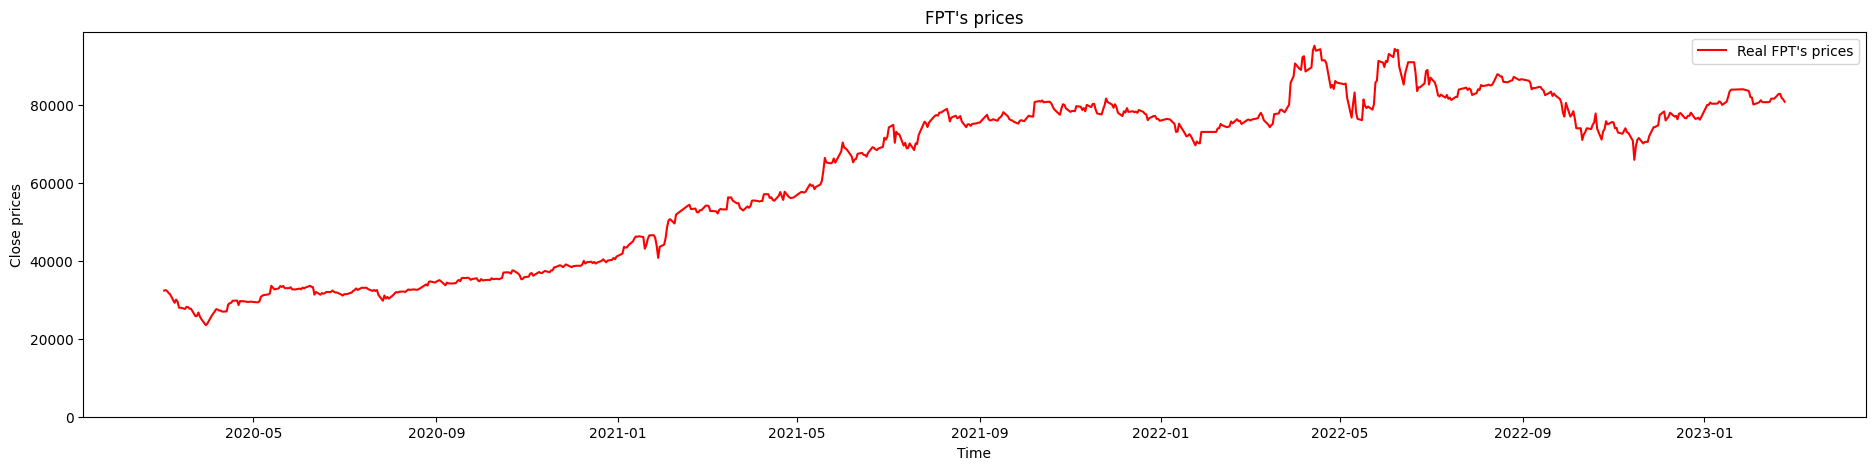

In [ ]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() 
plt.show()

In [ ]:
#Exporting data
df.to_csv(f"data\prepaired/{company}pre.csv", encoding = "utf-8")

Processing Data

In [ ]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [ ]:
#Fit data
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}']
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [ ]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,AR,...,SD_21,SD_28,Ske_7,Ske_14,Ske_21,Ske_28,Kur_7,Kur_14,Kur_21,Kur_28
27,27,32015.0,32654.0,31841.0,32364.0,1787060,2020-03-02,813.0,-349.0,-2.329513,...,822.178868,1030.508810,-1.161866,-0.788379,-0.347562,0.050891,1.481544,0.766863,-0.907817,-0.612280
28,28,32654.0,33119.0,32364.0,32480.0,1193800,2020-03-03,755.0,174.0,4.339080,...,775.695384,966.695591,-1.329729,-1.061289,-0.396084,-0.124220,1.356935,1.207903,-0.861868,-0.677261
29,29,32247.0,32247.0,31899.0,32247.0,1660790,2020-03-04,348.0,0.0,inf,...,713.311356,907.838671,-1.216103,-1.352764,-0.467931,-0.299519,1.453299,1.949859,-0.757901,-0.714949
30,30,32247.0,32480.0,31724.0,31724.0,1296450,2020-03-05,756.0,523.0,1.445507,...,632.267608,842.267030,-0.397156,-1.386952,-0.396097,-0.501344,-1.173580,2.087743,-0.760794,-0.820772
31,31,31492.0,31550.0,31085.0,31376.0,1305030,2020-03-06,465.0,116.0,4.008621,...,623.487763,831.830454,-0.872488,-1.326069,-0.436504,-0.422820,-0.334081,1.731924,-0.612545,-0.796433


In [ ]:
#Training seq X and output value Y
pre_day = 7
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day : i])
    y_total.append(scaled_data_y[i])
    print(i - pre_day, i, i)

0 7 7
1 8 8
2 9 9
3 10 10
4 11 11
5 12 12
6 13 13
7 14 14
8 15 15
9 16 16
10 17 17
11 18 18
12 19 19
13 20 20
14 21 21
15 22 22
16 23 23
17 24 24
18 25 25
19 26 26
20 27 27
21 28 28
22 29 29
23 30 30
24 31 31
25 32 32
26 33 33
27 34 34
28 35 35
29 36 36
30 37 37
31 38 38
32 39 39
33 40 40
34 41 41
35 42 42
36 43 43
37 44 44
38 45 45
39 46 46
40 47 47
41 48 48
42 49 49
43 50 50
44 51 51
45 52 52
46 53 53
47 54 54
48 55 55
49 56 56
50 57 57
51 58 58
52 59 59
53 60 60
54 61 61
55 62 62
56 63 63
57 64 64
58 65 65
59 66 66
60 67 67
61 68 68
62 69 69
63 70 70
64 71 71
65 72 72
66 73 73
67 74 74
68 75 75
69 76 76
70 77 77
71 78 78
72 79 79
73 80 80
74 81 81
75 82 82
76 83 83
77 84 84
78 85 85
79 86 86
80 87 87
81 88 88
82 89 89
83 90 90
84 91 91
85 92 92
86 93 93
87 94 94
88 95 95
89 96 96
90 97 97
91 98 98
92 99 99
93 100 100
94 101 101
95 102 102
96 103 103
97 104 104
98 105 105
99 106 106
100 107 107
101 108 108
102 109 109
103 110 110
104 111 111
105 112 112
106 113 113
107 114 114
108 11

In [ ]:
#Set test
test_size = 365

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
eval_set = [(x_train, y_train), (x_test, y_test)]

(376, 7, 31) (376, 1) (365, 7, 31) (365, 1)


Build Model

In [ ]:
# #Layers
def CreateModel(cells = 248):
    model = Sequential()
    cells = 248
    model.add(LSTM(units = cells, activation='tanh', recurrent_activation='sigmoid', input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
    model.add(Dropout(0.1))
    model.add(Dense(units = len(cols_y)))                     
    return model
model = CreateModel()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 10, batch_size = 2, use_multiprocessing = True, validation_split=0.2, shuffle=True)#Fit input to taget

Epoch 1/10
150/150 [==============================] - 3s 8ms/step - loss: 0.0072 - accuracy: 0.0033 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 0.0033 - val_loss: 7.8937e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
150/150 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.0033 - val_loss: 6.4289e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 6.4142e-04 - accuracy: 0.0033 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/10
150/150 [==============================] - 1s 5ms/step - loss: 9.5838e-04 - accuracy: 0.0033 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/10
150/150 [==============================] - 1s 6ms/step - loss: 5.4763e-04 - accuracy: 0.0033 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 7/10
150/150 [==============================] - 1s 5ms/step - loss: 7.1356e-04 - accuracy: 0.0033 

12/12 [==============================] - 0s 4ms/step


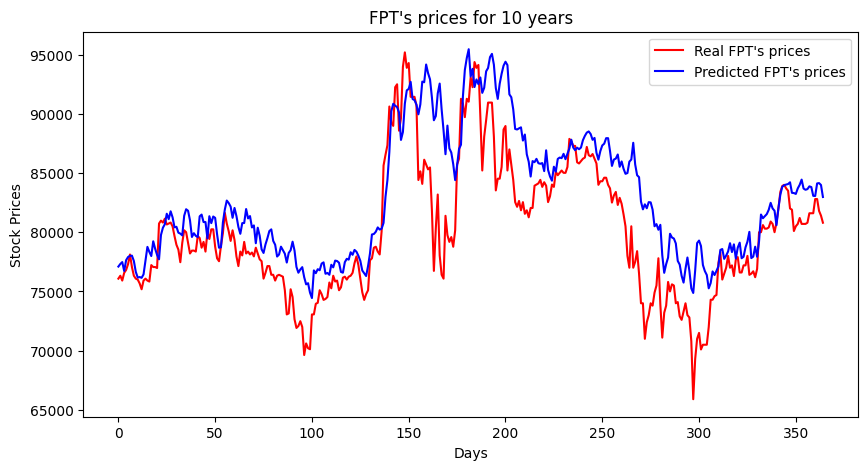

In [ ]:
#Config real price
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

#Predicted days
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(real_price, color="red", label=f"Real {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
ax.set_title(f"{company}'s prices for 10 years")
ax.set_xlabel("Days")
ax.set_ylabel("Stock Prices")
ax.legend()
plt.show()

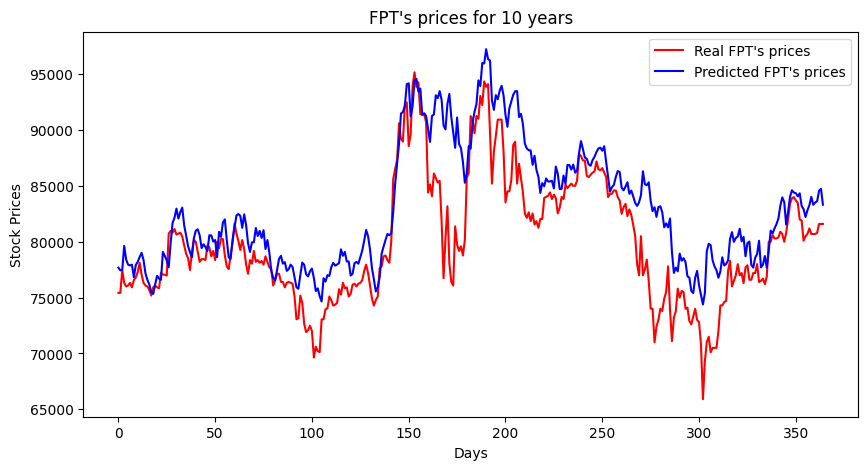

2019
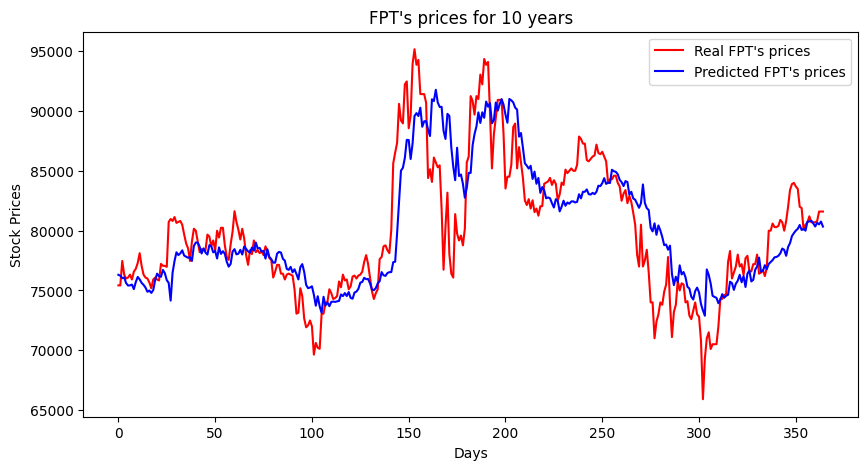

In [ ]:
#Save model
from keras.models import save_model

save_model(model, f"model/{company}.h5", include_optimizer = True)

# Deploy product

Load model

1/1 [==============================] - 0s 326ms/step


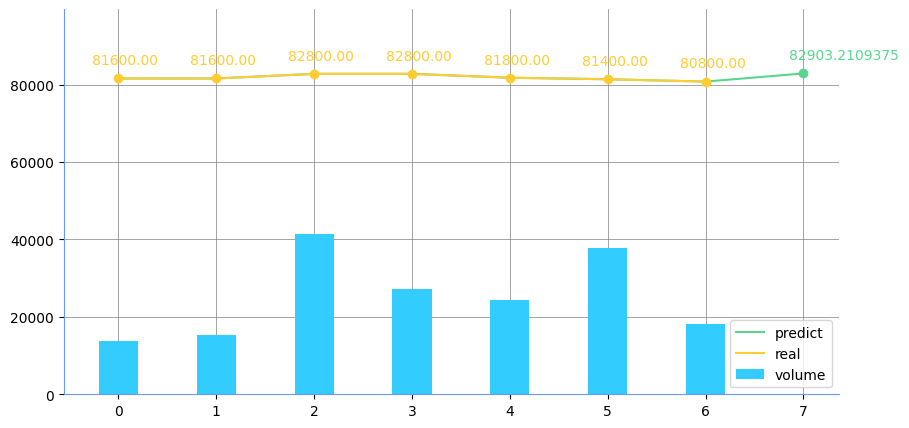

In [ ]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM    
# company = 'HAG'
df = pd.read_csv(f"./data/prepaired/{company}pre.csv", encoding = "utf-8")
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}'] #Variables for training
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
model = Sequential()
cells = 128
model.add(LSTM(units = cells, activation='tanh', recurrent_activation='sigmoid', input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
model.add(Dropout(0.1))
model.add(Dense(units = len(cols_y)))  
model = load_model(f"./model/{company}.h5")
real_prices = df.loc[len(df)-7:, ['Close', 'Volume']]
real_prices = np.array(real_prices)
predict_prices = real_prices[:, 0]
x_predict = df[len(df)-7:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scaler_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))
prediction = model.predict(x_predict)
prediction = scaler_y.inverse_transform(prediction)
predict_prices = np.append(predict_prices, prediction)
font = "Segoe UI"  
font_color = "black"  
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True, linewidth=0.5, color='gray', zorder=1)
if predict_prices[6] < predict_prices[7]:
    ax.plot(predict_prices, color="#58D68D", label=f"predict", zorder=2)
else:
    ax.plot(predict_prices, color="#FF6666", label=f"predict", zorder=2)
ax.plot(real_prices[:, 0], color="#FFCC33", label=f"real", zorder=2)
real_volumes = np.multiply(real_prices[:, 1], (np.max(predict_prices)/2/(np.max(real_prices[:, 1]))))
x = np.arange(len(real_volumes))  
width = 0.4  
ax.bar(x - width/2, real_volumes , width, color="#33CCFF", label='volume', align='edge', zorder=2)
ax.scatter(np.arange(len(real_prices[:, 0])), real_prices[:, 0], color='#FFCC33', zorder=2)
for i, price in enumerate(real_prices[:, 0]):
    ax.annotate(f"{price:.2f}", (i, real_prices[i, 0]), xytext=(5, 10), textcoords='offset points', color='#FFCC33', ha='center', zorder=2)
if predict_prices[6] < predict_prices[7]:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#58D68D", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#58D68D",zorder=2 )
else:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#FF6666", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#FF6666", zorder=2)
ax.legend(loc= 'lower right')
ax.spines['bottom'].set_color('#6699FF')
ax.spines['left'].set_color('#6699FF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors=font_color)

ax.set_ylim(0, np.max(predict_prices)*1.2)
# plt.savefig(f"./gui/images/svg_images/{company}.svg", format="svg", transparent=True)
plt.show()

#Relationship



12/12 [==============================] - 0s 5ms/step


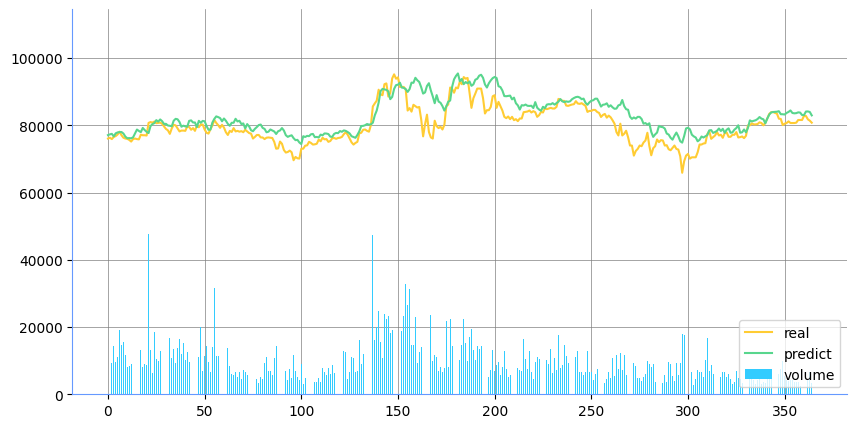

In [ ]:
real_prices = df.loc[len(df)-365:, ['Close', 'Volume']]
real_prices = np.array(real_prices)
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)
font = "Segoe UI"  
font_color = "black"  
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True, linewidth=0.5, color='gray', zorder=1)
ax.plot(real_prices[:, 0], color="#FFCC33", label=f"real", zorder=2)
ax.plot(predict_prices, color="#58D68D", label=f"predict", zorder=2)
real_volumes = np.multiply(real_prices[:, 1], (np.max(predict_prices)/2/(np.max(real_prices[:, 1]))))
x = np.arange(len(real_volumes))  
width = 0.4  
ax.bar(x - width/2, real_volumes , width, color="#33CCFF", label='volume', align='edge', zorder=2)
ax.legend(loc= 'lower right')
ax.spines['bottom'].set_color('#6699FF')
ax.spines['left'].set_color('#6699FF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors=font_color)
ax.set_ylim(0, max(np.max(predict_prices)*1.2, np.max(real_prices[:, 0])*1.2))
plt.show()